# Preparation

Pertama, kita install dulu semua library yang kita butuhin:

- mediapipe
- opencv-python

In [1]:
!pip install mediapipe opencv-python

Setelah itu, kita import librarynya

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from IPython.display import YouTubeVideo
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

Sekarang kita tes dulu apakah kameranya bisa digunakan atau tidak..

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Mediapipe Feed', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

## Tutup kamera dengan pencet tombol Q

# Introduction

Pada assignment ini, saya ingin coba untuk implementasi apakah seseorang bisa mengikuti 3 pose pada perkenalan diri (Jikoshoukai) Ella JKT48 atau tidak. Berikut adalah perkenalan diri Ella JKT48:

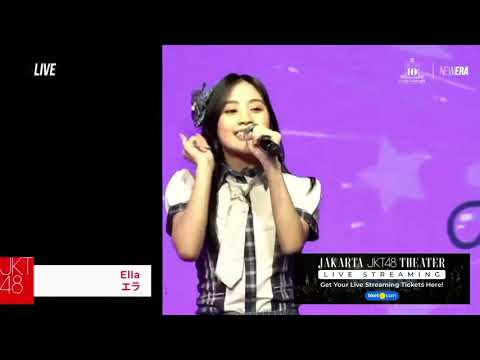

In [4]:
YouTubeVideo('pTPnmyzkBUw', width=854, height=480)

Dari video di atas, kita bisa lihat ada 3 pose yang dilakukan oleh Ella JKT48 ketika dia memperkenalkan dirinya:
- Ohayo, dengan tangan diangkat serong ke kanan atas dengan telapak tangan dibuka,
- Konnichiwa, dengan tangan kanan dikepalkan dan bertumpu pada pinggang,
- Oyasumi, dengan telapak tangan dibuka lebar dan ditempelkan pada pipi kanan, lengan ditempelkan pada tubuh.


Berdasarkan 3 pose itu, ada beberapa titik yang kita harus hitung sudutnya untuk mendapatkan akurasi perkenalan diri Ella JKT48 (lihat gambar di bawah):
- Ohayo, membutuhkan sudut ≈180° di titik 14 dan sudut 150°<x<170° di titik 12,
- Konnichiwa, membutuhkan sudut 100°<x<130° di titik 14 dan sudut 120°<x<130° di titik 12,
- Oyasumi, membutuhkan sudut <40° di titik 14 dan sudut 100°<x<130° di titik 12.

Namun untuk mentrigger ketiga pose tersebut, tangan kiri harus ikut berpose memegang microphone dengan sudut 10°<x<50° di titik 13 dan 90°<x<130° di titik 11.

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# Calculation

Pertama, kita harus menghitung dulu sudut pada sebuah titik dengan rumus berikut:

In [5]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

# Video capture, rendering calculation, and render stage state

Kita create dulu mediapipe instance yang akan kita sebut sebagai pose. Nah di dalam instance ini akan ada proses yang berulang (loop) selagi webcam kita masih terbuka.

Lalu di dalam loop ini, proses berikut akan terus berulang hingga kita pencet tombol Q untuk menutup jendela webcamnya:

1. Kita ambil dulu frame dari webcamnya.
2. Kita konversi gambar frame tersebut dari BGR ke RGB (konvensi dari openCV, defaultnya adalah BGR) dan dimasukkan ke variabel image
3. Kita proses dan deteksi "skeleton" dari gambar tadi dan dimasukkan ke variabel results
4. Image kita kembalikan dari RGB ke BGR
5. Kita coba ekstrak landmark yang ada di results, dan jika tidak berhasil, maka akan lompat ke langkah berikutnya:

        a. Kita ambil semua landmark di results dan masukkan ke variable landmarks
        b. Kita ambil semua koordinat landmark yang kita butuhin (bahu kiri dan kanan, siku kiri dan kanan, pergelangan tangan kiri dan kanan)
        c. Kita hitung sudut pada titik 11, 12, 13, dan 14
        d. Kita render sudut di masing-masing titik
        e. Kita ganti state dari stage sesuai sudut-sudut yang terkalkulasi sebelumnya sesuai dengan logika yang ada di bawah
6. Kita render sebuah kotak, tulisan stage, dan stage statenya
7. Kita render seluruh landmark yang sudah kita "kerjakan" sebelumnya
8. Tampilkan dalam window
9. Ulangi proses hingga user/kita menekan tombol q

<img src="https://github.com/emilirgi18/Intro-to-AI---Mediapipe/blob/main/Untitled%20Diagram.drawio.png?raw=true">

In [6]:
cap = cv2.VideoCapture(0)
## Setup mediapipe instance
stage = None

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            r_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            r_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
            l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            l_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            l_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            # Calculate angle
            angle_14 = calculate_angle(r_shoulder, r_elbow, r_wrist)
            angle_12 = calculate_angle(l_shoulder, r_shoulder, r_elbow)
            angle_13 = calculate_angle(l_shoulder, l_elbow, l_wrist)
            angle_11 = calculate_angle(r_shoulder, l_shoulder, l_elbow)

            
            # Visualize angle
            cv2.putText(image, str(angle_14), tuple(np.multiply(r_elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, str(angle_12), tuple(np.multiply(r_shoulder, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, str(angle_13), tuple(np.multiply(l_elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, str(angle_11), tuple(np.multiply(l_shoulder, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            
            #Stage state logic
            if (10 < angle_13 and angle_13 < 50) and (90 < angle_11 and angle_11 < 130):
                if (170 < angle_14) and (150 < angle_12 and angle_12 < 170):
                    stage = "Ohayo!"
                if (100 < angle_14 and angle_14 < 130) and (120 < angle_12 and angle_12 < 130):
                    stage = "Konnichiwa!"
                if (40 > angle_14) and (100 < angle_12 and angle_12 < 130):
                    stage = "Oyasumi!"
            else:
                stage = "Ready"
                       
        except:
            pass
        
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Credits
Terima kasih untuk [Nicholas Renotte](https://www.youtube.com/watch?v=06TE_U21FK4&ab_channel=NicholasRenotte) untuk ilmunya dan [Ella JKT48](https://twitter.com/AM_EllaJKT48) untuk inspirasinya